Notebook intended for producing the results and plots for the term paper on 'Signal Analysis of Gravitational Waves.

The strain data can be found at:
https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW170814/v3/

The code requires the realigo library for manipulating the hdf5 files. It can be found here:
https://www.gw-openscience.org/static/sample_code/readligo.py


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import readligo as rl
from cmath import exp, pi
import h5py
from scipy.fft import rfftfreq, irfft, rfft
from scipy.signal import windows, butter, filtfilt, lfilter, freqz
from scipy.interpolate import interp1d

In [2]:
strain_l1, time, c_l1 = rl.loaddata('L114.hdf5')

#this is the approximate event time which is used in the papers
t_center=1186741861

fs = 4096    #sample rate
dt = 1/fs

Declaring constants and window functions

In [3]:
t_index = np.where((time >= t_center - 2) & (time < t_center + 2))          #4 second window around the event
t_index_long = np.where((time >= t_center - 512) & (time < t_center + 512)) #1024 second window around the event

N = len(strain_l1[t_index])         #number of data samples in the 4 second window
NFFT = 4*fs                         #block size used for PSD calaculations
NOVL = 1 * NFFT / 2                 #overlap value 
freq = np.fft.rfftfreq(N, dt)       #frequency bins for the 4s window data

dwindow = [windows.tukey(NFFT, alpha=0.25),windows.hann(NFFT),windows.hamming(NFFT), windows.boxcar(NFFT)]   #window functions used for analysis

#windowed strain data
strain_wind = [dwindow[0]*strain_l1[t_index],dwindow[1]*strain_l1[t_index],dwindow[2]*strain_l1[t_index], dwindow[3]*strain_l1[t_index]]

Calculating Power Spectral Density

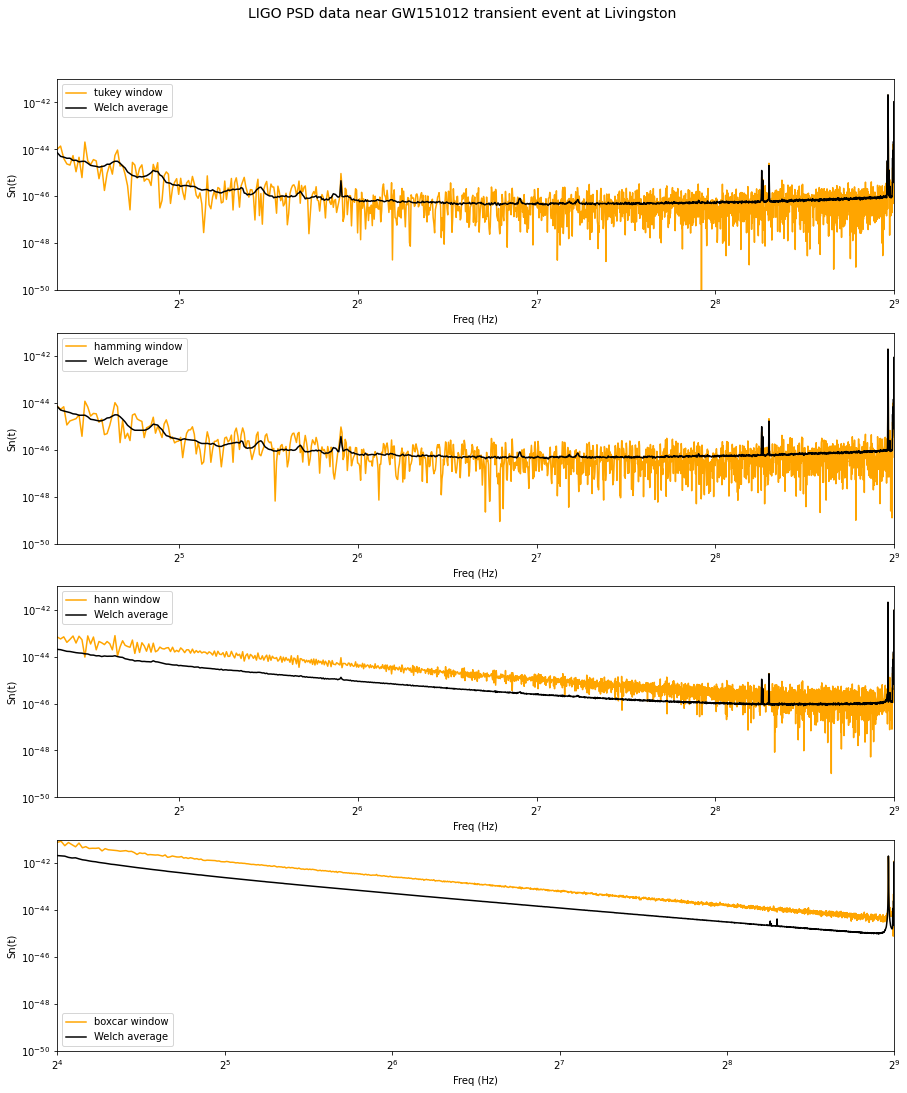

In [4]:
psd_l1=[]
freq_l1=[]
no_avg_psd=[]
no_avg_freq=[]

#loop for determining PSD for averaged and non-averaged data
for i in range(len(dwindow)):
    
    psd_1 , freq_1 = ml.psd(strain_l1[t_index_long], Fs = fs, NFFT = NFFT, window = dwindow[i], noverlap = NOVL)
    
    psd_l1.append(psd_1)
    
    freq_l1.append(freq_1)
    
    psd_2, freq_2 = ml.psd(strain_l1[t_index],Fs = fs, NFFT = NFFT, window = dwindow[i])
    
    no_avg_psd.append(psd_2)
    
    no_avg_freq.append(freq_2)

#interpolation function used for whitening later     
psd_l1_intrp = interp1d(freq_l1[0], psd_l1[0])    

#generating plots os PSD data
fig = plt.figure(figsize=(15,20))
st = plt.suptitle('LIGO PSD data near GW151012 transient event at Livingston',fontsize=14)
st.set_y(0.85)
fig.subplots_adjust(top=0.8)

plt.subplot(4,1,1)
plt.xscale('log',base=2)
plt.yscale('log',base=10)
plt.plot(no_avg_freq[0], no_avg_psd[0],c = 'orange',label='tukey window')
plt.plot(freq_l1[0], psd_l1[0],c = 'black',label='Welch average')
plt.ylabel('Sn(t)')
plt.xlabel('Freq (Hz)')
plt.axis([20, 512, 1e-50, 1e-41])
plt.legend()

plt.subplot(4,1,2)
plt.xscale('log',base=2)
plt.yscale('log',base=10)
plt.plot(no_avg_freq[1], no_avg_psd[1],c = 'orange',label='hamming window')
plt.plot(freq_l1[1], psd_l1[1],c = 'black',label = 'Welch average')
plt.ylabel('Sn(t)')
plt.xlabel('Freq (Hz)')
plt.axis([20, 512, 1e-50, 1e-41])
plt.legend()

plt.subplot(4,1,3)
plt.xscale('log',base=2)
plt.yscale('log',base=10)
plt.plot(no_avg_freq[2], no_avg_psd[2],c = 'orange',label = 'hann window')
plt.plot(freq_l1[2], psd_l1[2], c = 'black',label = 'Welch average')
plt.ylabel('Sn(t)')
plt.xlabel('Freq (Hz)')
plt.axis([20, 512, 1e-50, 1e-41])
plt.legend()


plt.subplot(4,1,4)
plt.xscale('log',base=2)
plt.yscale('log',base=10)
plt.plot(no_avg_freq[3], no_avg_psd[3],c = 'orange', label='boxcar window')
plt.plot(freq_l1[3], psd_l1[3], c = 'black', label ='Welch average')
plt.ylabel('Sn(t)')
plt.xlabel('Freq (Hz)')
plt.axis([16, 512, 1e-50, 1e-41])
plt.legend()

plt.show()

Calculating the peak frequency in the theoretical range

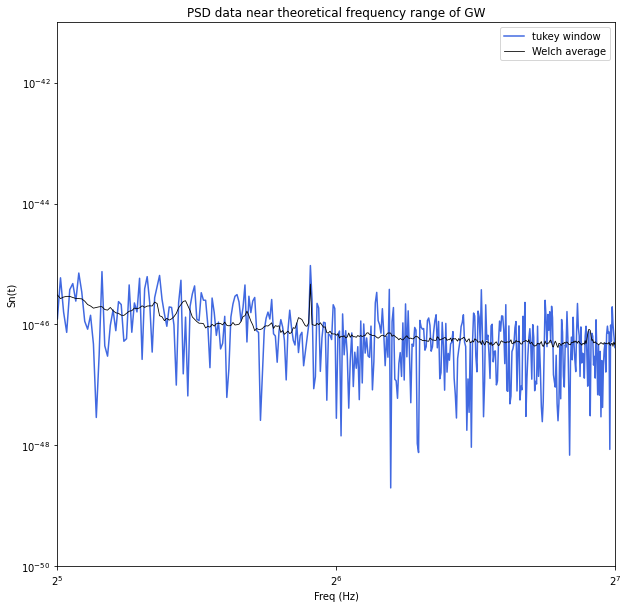

In [13]:
#PSD data in the theoretical range of compact binary merger GW frequency

plt.figure(figsize=(10,10))
plt.title('PSD data near theoretical frequency range of GW')

plt.xscale('log',base=2)
plt.yscale('log',base=10)

plt.plot(no_avg_freq[0], no_avg_psd[0],c = 'royalblue',label='tukey window')
plt.plot(freq_l1[0], psd_l1[0],c = 'black',label = 'Welch average',linewidth=0.8)

plt.ylabel('Sn(t)')
plt.xlabel('Freq (Hz)')
plt.axis([32, 128, 1e-50, 1e-41])
plt.legend()

plt.show()

In [50]:
#finding a rough estimate for GW strain peak frequency

freq_strain = list(zip(freq_l1[0],psd_l1[0]))

freq_strain_ar = np.array(freq_strain)

max_strain = 0
max_freq = 0
for i in range(128,256):
    if  freq_strain_ar[i,1] > max_strain:
        max_strain = freq_strain_ar[i,1]
        max_freq = freq_strain_ar[i,0]
        
print(max_freq)

60.0


Whitening the frequency domain data and transforming to time domain

In [5]:
freq_bins = np.fft.rfftfreq(N, dt)

strain_tf = np.fft.rfft(strain_wind[0])

norm = (1/(np.sqrt(1/2*dt)))

white_freq = strain_tf/(np.sqrt(psd_l1_intrp(freq_bins))*norm)

strain_whitened = np.fft.irfft(white_freq, n = N)

Applying band-pass filter to the whitened time domain data

In [6]:
fband = [32,128]

bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')

normal = np.sqrt((fband[1]-fband[0])/(fs/2))

strain_bp = filtfilt(bb, ab, strain_whitened) / normal

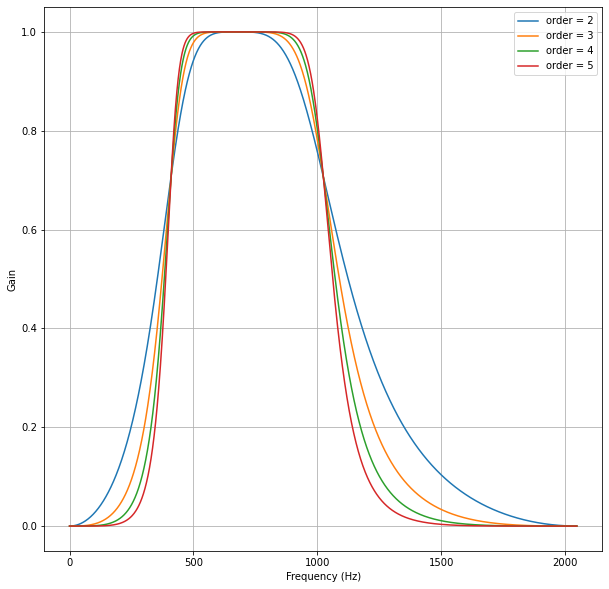

In [68]:
#comparative analysis of different orders of butterworth band-pass filter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

plt.figure(figsize=(10,10))
plt.clf()
for order in [2, 3, 4,5]:
    b, a = butter_bandpass(500, 1250, 5000, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid()
plt.legend()    
plt.show()

Plotting the obtained data

(-2.0, 2.0)

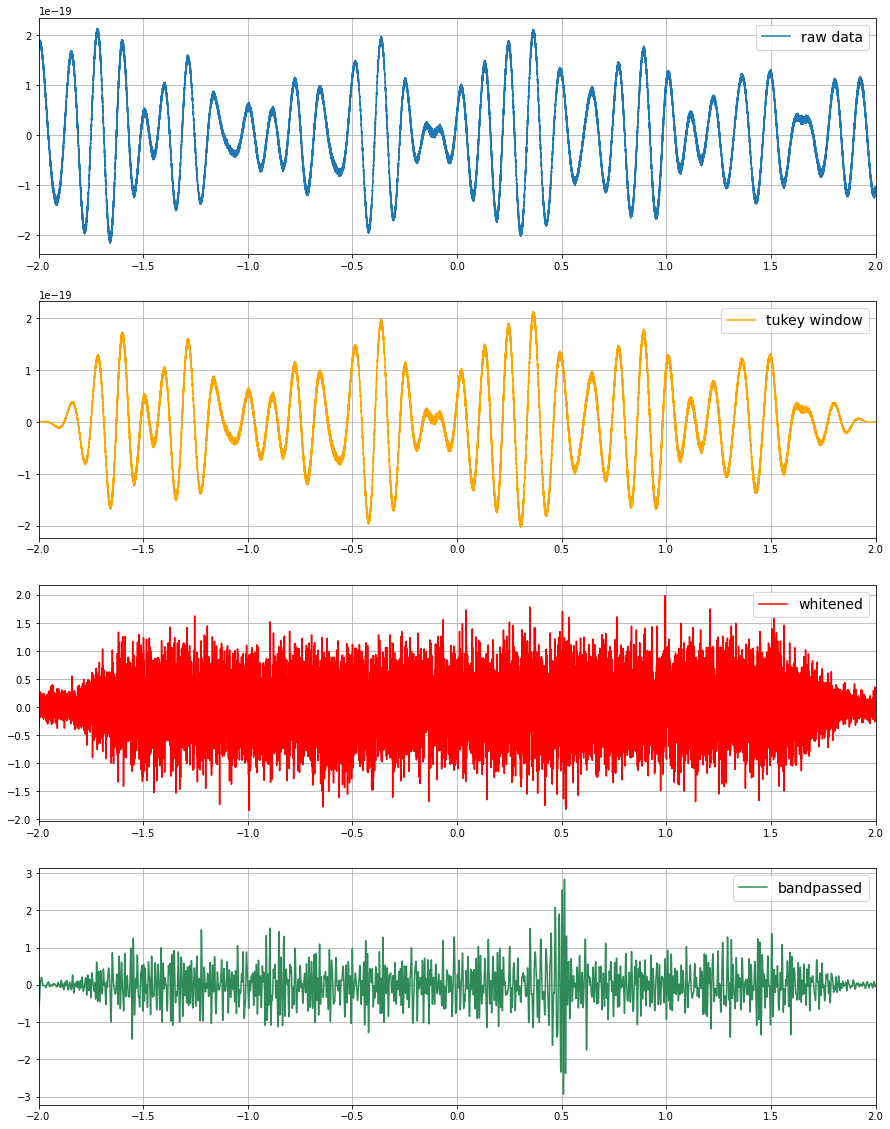

In [72]:
#comparision plots

plt.figure(figsize=(15,20))
plt.subplot(4, 1, 1)
plt.plot(time[t_index]-t_center,strain_l1[t_index],label='raw data')
plt.legend(fontsize=14)
plt.xlim([-2,2])
plt.grid()

plt.subplot(4,1,2)
plt.plot(time[t_index]-t_center,strain_wind[0],label='tukey window',c='orange')
plt.xlim([-2,2])
plt.legend(fontsize=14)
plt.grid()

plt.subplot(4,1,3)
plt.plot(time[t_index]-t_center,strain_whitened,label='whitened', c = 'red')
plt.legend(fontsize=14)
plt.grid()
plt.xlim([-2,2])

plt.subplot(4,1,4)
plt.plot(time[t_index]-t_center,strain_bp,label='bandpassed',c='seagreen')
plt.legend(fontsize=14)
plt.grid()
plt.xlim([-2,2])
